# Comparison of Loan Default Rates Before and After Prosper Relaunched Their Services
## by Johnson Yang

## Investigation Overview

In this investigation we want to look at the default rate differences before and after Prosper reopened their website in July 2009. We are especially interested in the fluctuation of default rates between the transition of Prosper, and will examine if the relaunch has made the Prosper marketplace trustworthy.

## Dataset Overview

There are 113,937 loan listings in the dataset with 81 features. Among these features, 61 of them are numerical variables, 3 are boolean variables, and 17 are string variables.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

# https://stackoverflow.com/questions/61503183/how-can-i-add-grid-lines-to-a-catplot-in-seaborn
sb.set_style(style="darkgrid")

In [2]:
# Load in the dataset into a pandas DataFrame
df_loan = pd.read_csv('prosperLoanData.csv')

In [3]:
# Various data wrangling operations

df_loan.loc[(df_loan['CreditGrade'].isnull() == True) & (df_loan['ProsperRating (Alpha)'].isnull() == True), 'ProsperRating (numeric)'] = 0.0
df_loan.loc[(df_loan['CreditGrade'].isnull() == True) & (df_loan['ProsperRating (Alpha)'].isnull() == True), 'ProsperRating (Alpha)'] = 'NC'

df_loan['ListingCreationDate'] = pd.to_datetime(df_loan['ListingCreationDate'])
df_loan['ClosedDate'] = pd.to_datetime(df_loan['ClosedDate']).dt.date
df_loan['DateCreditPulled'] = pd.to_datetime(df_loan['DateCreditPulled'])
df_loan['FirstRecordedCreditLine'] = pd.to_datetime(df_loan['FirstRecordedCreditLine']).dt.date
df_loan['LoanOriginationDate'] = pd.to_datetime(df_loan['LoanOriginationDate']).dt.date

df_loan = df_loan.rename(columns={'LoanStatus':'LoanStatus_Original'})
df_loan['LoanStatus'] = df_loan['LoanStatus_Original']
df_loan.loc[df_loan['LoanStatus'].str.contains('Past') == True, 'LoanStatus'] = 'Defaulted'
df_loan.loc[df_loan['LoanStatus'].str.fullmatch('FinalPaymentInProgress') == True, 'LoanStatus'] = 'Current'

## Distribution of Loan Status Types

There are 11,992 loans which were considered chargedoff, and 7,085 loans which were labeled as defaulted in the dataset. If we convert these loan counts to percent proportions, this would mean the overall chargedoff rate is 10.5251%, and the overall defaulted rate is 6.2183%.

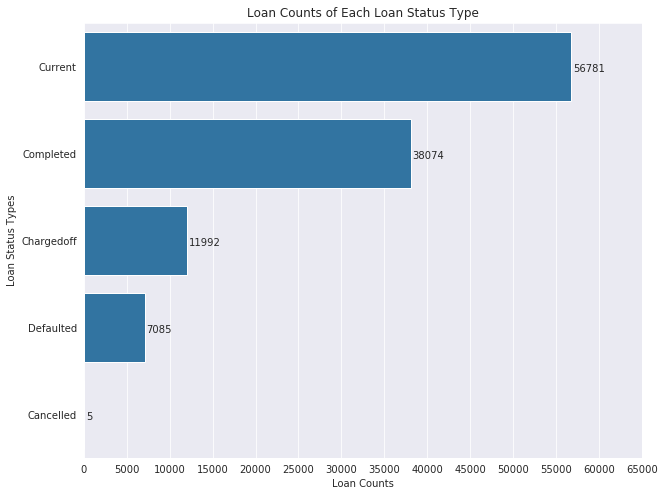

In [4]:
plt.figure(figsize=(10,8))
plot_barh = sb.countplot(data=df_loan, y='LoanStatus', order=df_loan.LoanStatus.value_counts().index, orient='h', color=sb.color_palette()[0])
plt.xticks(np.arange(0, 70000, 5000))
plt.title("Loan Counts of Each Loan Status Type")
plt.xlabel("Loan Counts")
plt.ylabel("Loan Status Types")

for barh in plot_barh.patches:
    plt.annotate("%.0f" % barh.get_width(), (barh.get_x() + barh.get_width(), barh.get_y()), xytext=(2, -40), textcoords='offset points')

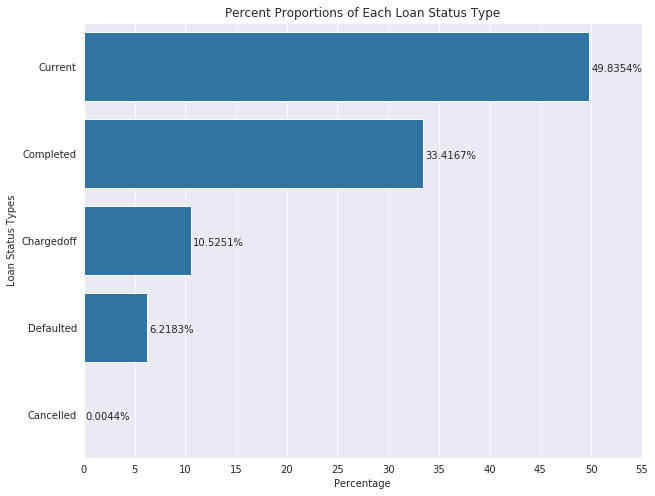

In [5]:
plt.figure(figsize=(10,8))
plot_barh = sb.barplot(data=(df_loan.LoanStatus.value_counts(normalize=True)*100).reset_index(), x='LoanStatus', y='index', orient='h', color=sb.color_palette()[0])
plt.xticks(np.arange(0, 60, 5))
plt.title("Percent Proportions of Each Loan Status Type")
plt.xlabel("Percentage")
plt.ylabel("Loan Status Types")

for barh in plot_barh.patches:
    plt.annotate('{0:.4f}%'.format(barh.get_width()), (barh.get_x() + barh.get_width(), barh.get_y()), xytext=(2, -40), textcoords='offset points')

## Comparison of Overall Loan Default Rates Between Prosper Transition

The way Prosper [evaluates the credit risk of a loan](https://en.wikipedia.org/wiki/Prosper_Marketplace#Evaluation_of_credit_risk) is different between transition. Before Prosper obtained SEC registration for its loans in July 2009, Prosper used an internal "Credit Grades" model to assess the credit rating of its loans. After 2009 SEC registration, Prosper created a new "Prosper Rating" model to replace their old rating model, and also introduced other measures such as FICO credit score requirements. Though both "Credit Grades" and "Prosper Rating" use the same alphabet-based rating categories, the reliability of the new model is profound.

Before July 2009, even AA-grade loans have a high overall default rate of 9.6609%. After July 2009, even C-grade loans have a relatively stable overall default rate of 3.8485%. But loans below C-grade are still very risky for investors.

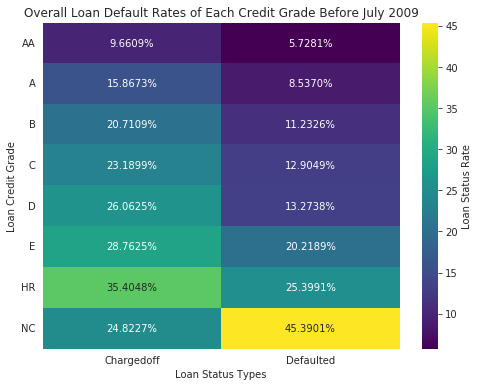

In [6]:
credit_grade = ['AA', 'A', 'B', 'C', 'D', 'E', 'HR', 'NC']
loan_status = ['Chargedoff', 'Defaulted']

list_c = []
list_d = []

for i in credit_grade:
    list_c.append(df_loan.query('CreditGrade == "{}" & LoanStatus == "Chargedoff"'.format(i)).shape[0] / df_loan.query('CreditGrade == "{}"'.format(i)).shape[0] * 100)
    list_d.append(df_loan.query('CreditGrade == "{}" & LoanStatus == "Defaulted"'.format(i)).shape[0] / df_loan.query('CreditGrade == "{}"'.format(i)).shape[0] * 100)

default_rate = pd.DataFrame(data=[list_c, list_d], index=loan_status, columns=credit_grade)

plt.figure(figsize=(8,6))
ax = sb.heatmap(default_rate.transpose(), cmap="viridis", annot=True, fmt='.4f', cbar_kws={"label" : "Loan Status Rate"})
ax.tick_params(rotation=0)

plt.title("Overall Loan Default Rates of Each Credit Grade Before July 2009")
plt.xlabel("Loan Status Types")
plt.ylabel("Loan Credit Grade")

for t in ax.texts: t.set_text(t.get_text() + '%')

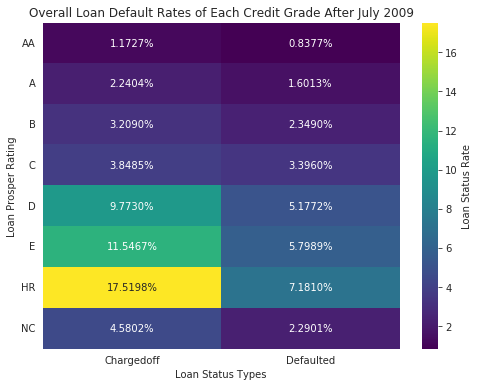

In [7]:
prosper_rating = ['AA', 'A', 'B', 'C', 'D', 'E', 'HR', 'NC']
loan_status = ['Chargedoff', 'Defaulted']

list_c = []
list_d = []

for i in prosper_rating:
    list_c.append(df_loan.loc[(df_loan['ProsperRating (Alpha)'] == "{}".format(i)) & (df_loan['LoanStatus'] == "Chargedoff")].shape[0] / df_loan.loc[df_loan['ProsperRating (Alpha)'] == "{}".format(i)].shape[0] * 100)
    list_d.append(df_loan.loc[(df_loan['ProsperRating (Alpha)'] == "{}".format(i)) & (df_loan['LoanStatus'] == "Defaulted")].shape[0] / df_loan.loc[df_loan['ProsperRating (Alpha)'] == "{}".format(i)].shape[0] * 100)

default_rate = pd.DataFrame(data=[list_c, list_d], index=loan_status, columns=prosper_rating)

plt.figure(figsize=(8,6))
ax = sb.heatmap(default_rate.transpose(), cmap="viridis", annot=True, fmt='.4f', cbar_kws={"label" : "Loan Status Rate"})
ax.tick_params(rotation=0)

plt.title("Overall Loan Default Rates of Each Credit Grade After July 2009")
plt.xlabel("Loan Status Types")
plt.ylabel("Loan Prosper Rating")

for t in ax.texts: t.set_text(t.get_text() + '%')

## Details of Loan Default Rates by Credit Grade and Occupation Before Prosper Transition

According to a [news report from the Wall Street Journal](https://www.wsj.com/articles/SB124088142201761953), the average lender return since Prosper started the business in 2006 was 2.8% after defaults. And when Prosper began to collect more information about the borrowers' credit and employment histories, the average lender returns just barely improved to 4.8%. We will try to see how bad the situation is during these days.

Before July 2009, an investor would have a hard time trying to find a dependable borrower. Only when borrowers match certain criteria in job and credit rating could you expect a default rate lower than 10%.

In [8]:
def draw_heatmap_multivar(df, heatmap_xaxis, heatmap_yaxis, column_xaxis, column_yaxis, loan_status_code, x_tick_order):
    """
    Creates an adapted 2d categorical heatmap using designated facet variables

    Args:
        df - original source of data
        heatmap_xaxis - list of labels for creating internal dataframe
        heatmap_yaxis - list of labels for creating internal dataframe
        column_xaxis - dataframe column name for x-axis of heatmap
        column_yaxis - dataframe column name for y-axis of heatmap
        loan_status_code - the LoanStatus code we want to create heatmap against
        x_tick_order - specify the order of xticklabels we want to display
    Returns:
        None
    """

    list_df = []

    for x in heatmap_xaxis:
        list_c = []
        for y in heatmap_yaxis:
            if df.query('`{}` == "{}" & `{}` == "{}"'.format(column_yaxis, y, column_xaxis, x)).shape[0] == 0:
                list_c.append(0)
            else:
                list_c.append(df.query('`{}` == "{}" & `{}` == "{}" & LoanStatus == "{}"'.format(column_yaxis, y, column_xaxis, x, loan_status_code)).shape[0] / df.query('`{}` == "{}" & `{}` == "{}"'.format(column_yaxis, y, column_xaxis, x)).shape[0] * 100)
        list_df.append(list_c)

    df_heatmap = pd.DataFrame(data=list_df, index=heatmap_xaxis, columns=heatmap_yaxis)
    default_rate = df_heatmap.transpose().reindex(columns=x_tick_order).sort_index().sort_values(by=x_tick_order)

    plt.figure(figsize=(12,20))
    ax = sb.heatmap(default_rate, cmap="viridis", annot=True, fmt='.4f', cbar=True, cbar_kws={"orientation": "horizontal", "pad": 0.05, "label" : "{} Rate".format(loan_status_code)})
    ax.tick_params(right=True, top=True, labelright=True, labeltop=True,rotation=0)

    for t in ax.texts: t.set_text(t.get_text() + '%')

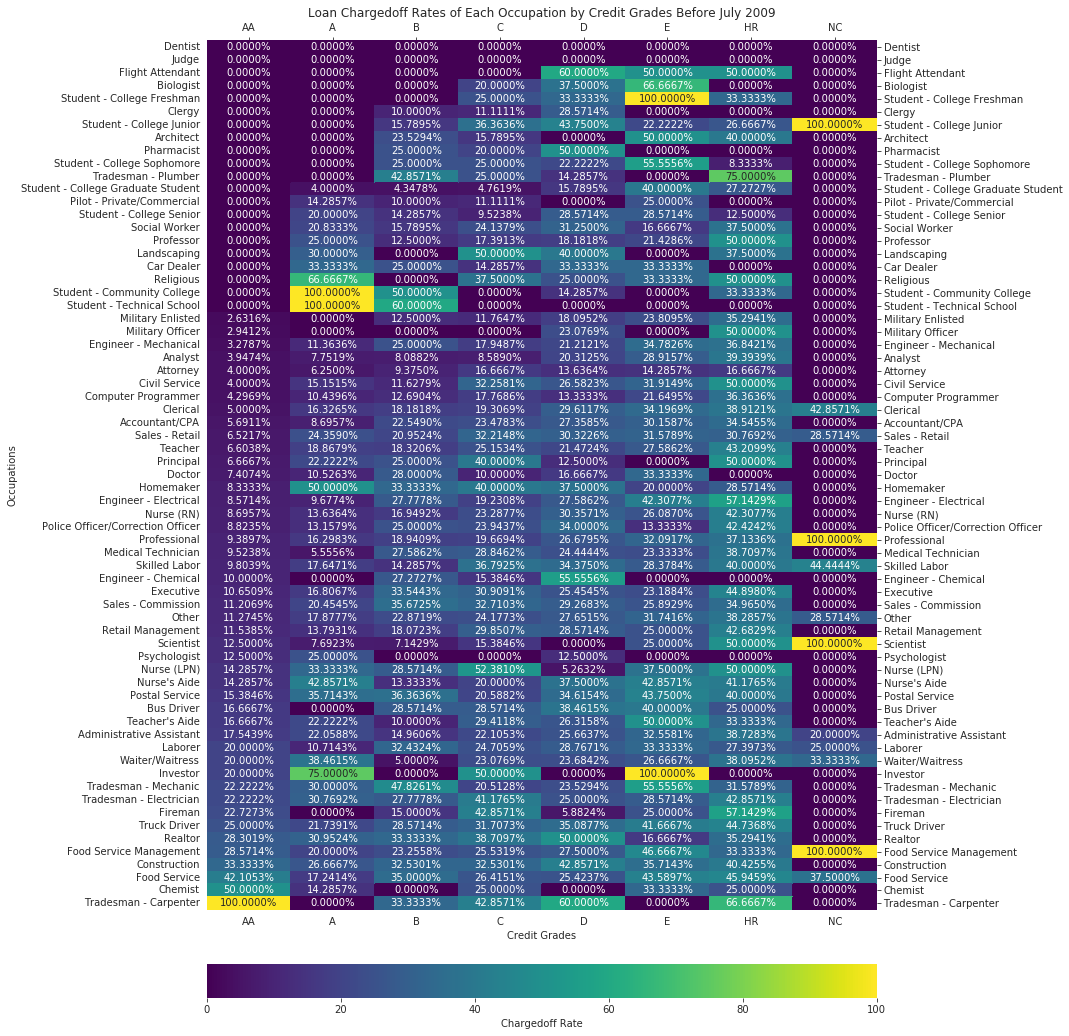

In [9]:
# Create a heatmap of loan default rates by credit grade and occupation
# Chargedoff and Defaulted will be plotted as separate heatmaps
occupation = df_loan.Occupation.value_counts().index.tolist()
credit_grade = df_loan['CreditGrade'].value_counts().index.tolist()
x_tick_order = ['AA', 'A', 'B', 'C', 'D', 'E', 'HR', 'NC']
draw_heatmap_multivar(df_loan, credit_grade, occupation, 'CreditGrade', 'Occupation', 'Chargedoff', x_tick_order)
plt.title("Loan Chargedoff Rates of Each Occupation by Credit Grades Before July 2009")
plt.xlabel("Credit Grades")
plt.ylabel("Occupations");

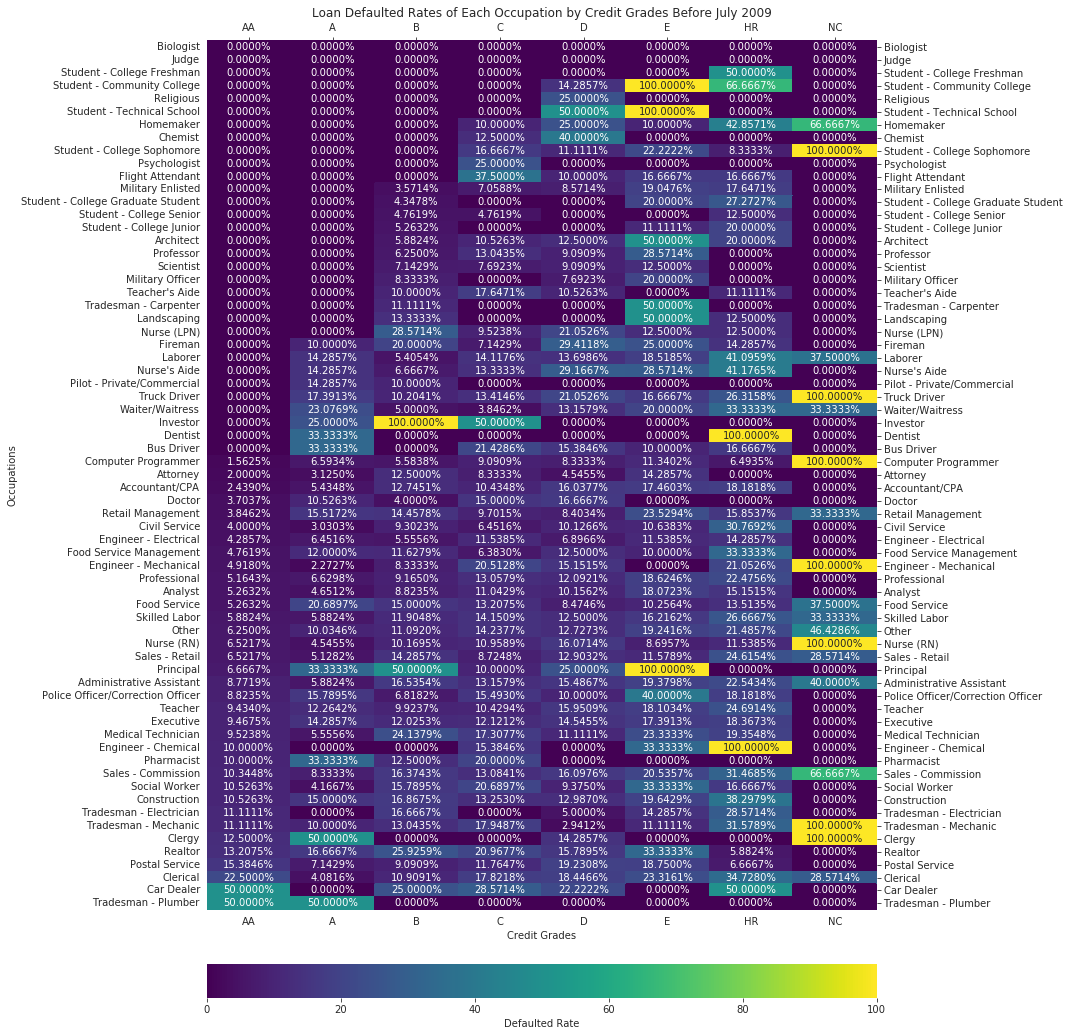

In [10]:
occupation = df_loan.Occupation.value_counts().index.tolist()
credit_grade = df_loan['CreditGrade'].value_counts().index.tolist()
x_tick_order = ['AA', 'A', 'B', 'C', 'D', 'E', 'HR', 'NC']
draw_heatmap_multivar(df_loan, credit_grade, occupation, 'CreditGrade', 'Occupation', 'Defaulted', x_tick_order)
plt.title("Loan Defaulted Rates of Each Occupation by Credit Grades Before July 2009")
plt.xlabel("Credit Grades")
plt.ylabel("Occupations");

## Details of Loan Default Rates by Prosper Rating and Occupation After Prosper Transition

The situation is completely different after July 2009. From the plots we can see there are only less than 10 occupations within AA-C grade that would be risky to invest in (i.e. chargedoff rate greater than 10%).

The results suggest that investors should avoid these loans if the borrowers' occupations match these specific jobs. But at the same time, it is also worrying to see college students being plagued by debt burdens before they can even graduate from school. This is an [ongoing problem](https://www.insidehighered.com/news/2019/11/18/most-college-students-work-and-thats-both-good-and-bad) in US that should be seriously taken, though it is beyond the scope of this report.

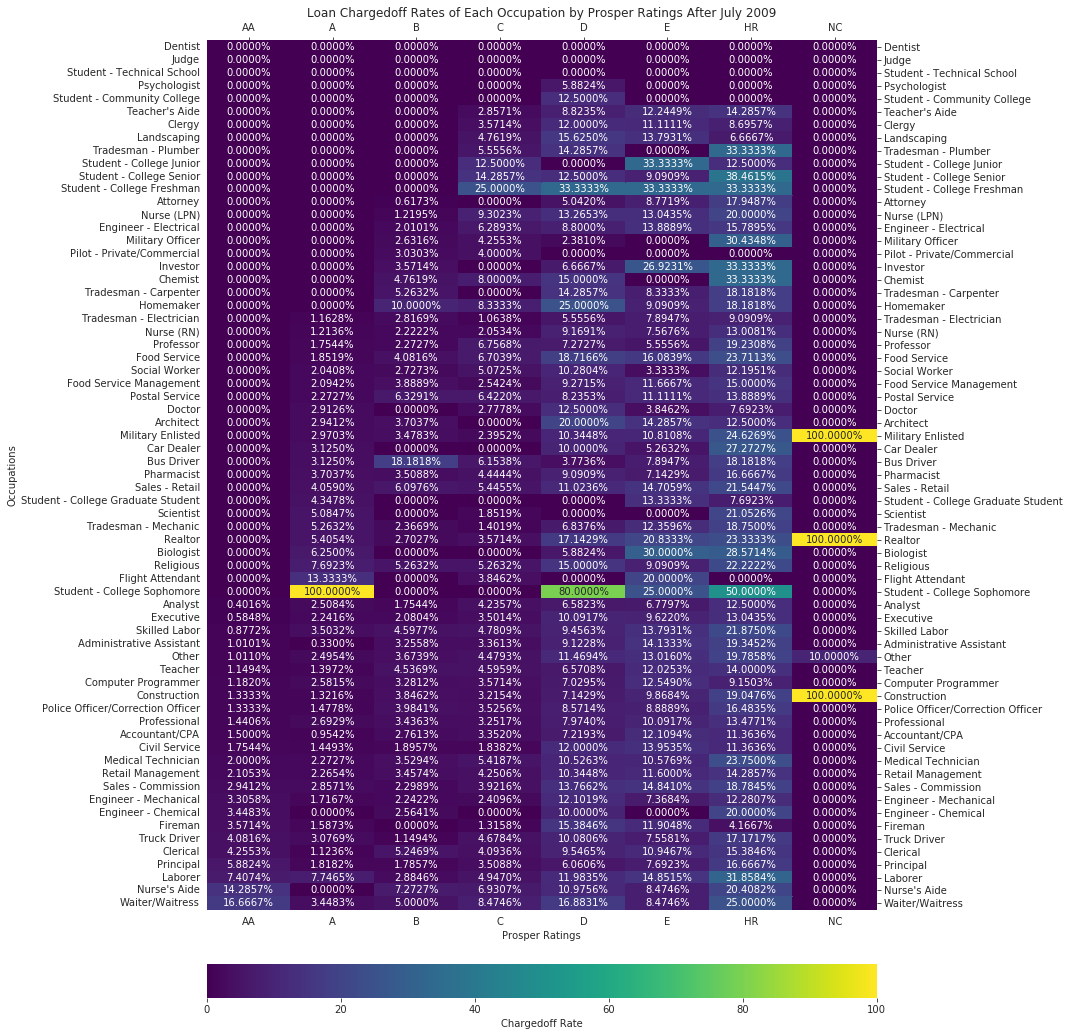

In [11]:
# Create a heatmap of loan default rates by prosper rating and occupation
# Chargedoff and Defaulted will be plotted as separate heatmaps
occupation = df_loan.Occupation.value_counts().index.tolist()
prosper_rating = df_loan['ProsperRating (Alpha)'].value_counts().index.tolist()
x_tick_order = ['AA', 'A', 'B', 'C', 'D', 'E', 'HR', 'NC']
draw_heatmap_multivar(df_loan, prosper_rating, occupation, 'ProsperRating (Alpha)', 'Occupation', 'Chargedoff', x_tick_order)
plt.title("Loan Chargedoff Rates of Each Occupation by Prosper Ratings After July 2009")
plt.xlabel("Prosper Ratings")
plt.ylabel("Occupations");

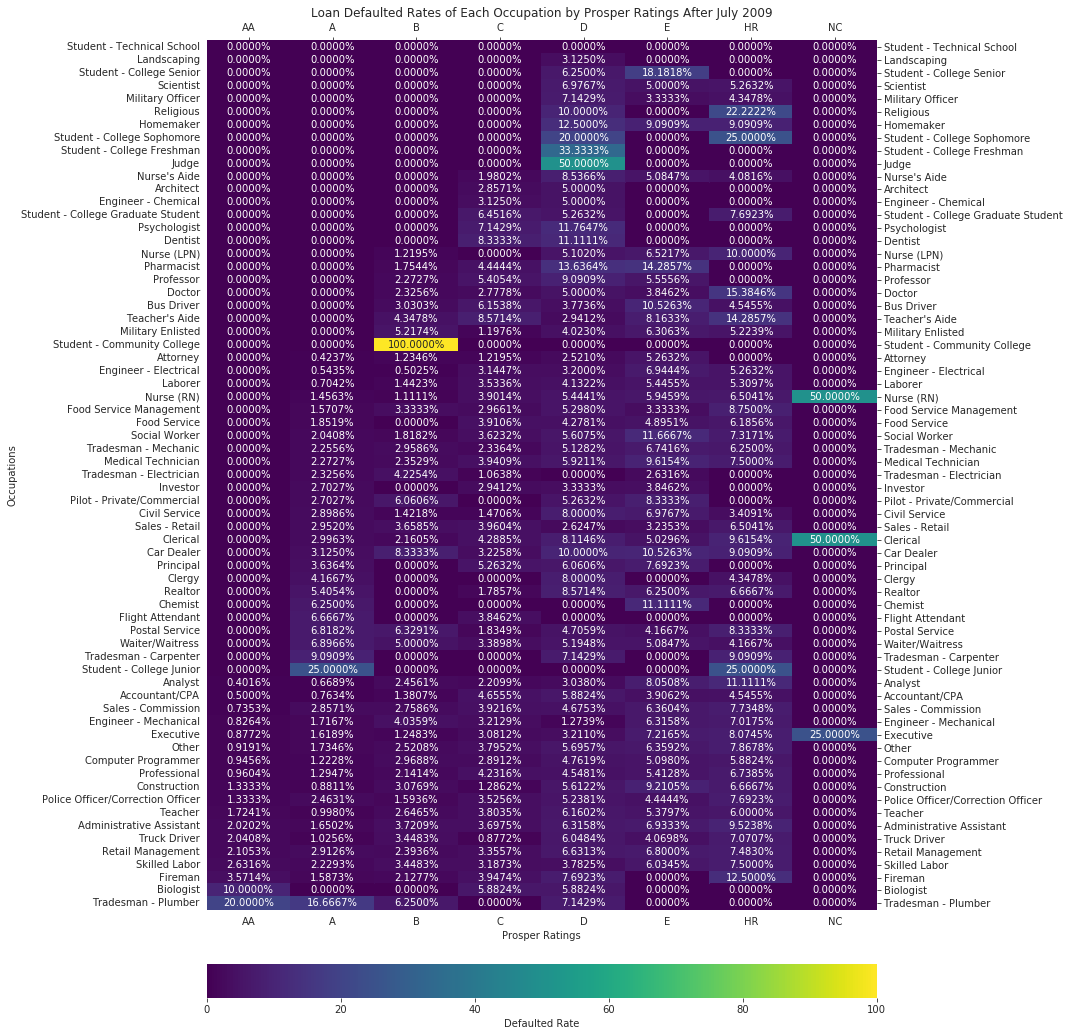

In [12]:
occupation = df_loan.Occupation.value_counts().index.tolist()
prosper_rating = df_loan['ProsperRating (Alpha)'].value_counts().index.tolist()
x_tick_order = ['AA', 'A', 'B', 'C', 'D', 'E', 'HR', 'NC']
draw_heatmap_multivar(df_loan, prosper_rating, occupation, 'ProsperRating (Alpha)', 'Occupation', 'Defaulted', x_tick_order)
plt.title("Loan Defaulted Rates of Each Occupation by Prosper Ratings After July 2009")
plt.xlabel("Prosper Ratings")
plt.ylabel("Occupations");